In [1]:
import torch
import pandas as pd
import numpy as np
import re
import gensim
import collections
import pyarabic.araby as araby
from nltk import ngrams

/home/amr/anaconda3/envs/torch/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import matplotlib.pyplot as plt

# Data
### Helping Functions

In [3]:
def normalization(t):
    t = araby.strip_tashkeel(t)
    t = araby.normalize_hamza(t)
    t = araby.normalize_alef(t)
    t = araby.strip_tatweel(t)
    t = araby.normalize_teh(t)
    t = re.sub("ى","ي",t)
    return t

### Data

In [4]:
data= np.load('../translation project/AD_NMT-master/LAV-MSA-2-both.pkl',allow_pickle=True)

In [5]:
data[0] # lav , msa

['لا انا بعرف وحدة راحت ع فرنسا و معا شنتا حطت فيها الفرش',
 'لا اعرف واحدة ذهبت الى فرنسا و لها غرفة و ضعت فيها الافرشة']

In [6]:
# extract only msa text
msa=[]
for i,ex in enumerate(data):
    msa_text = normalization(ex[1])
    data[i][1] = msa_text
    msa.append(msa_text)

In [7]:
msa = ' '.join(msa)

Dictionaries

In [8]:
msa_d=collections.Counter(msa.split())

In [9]:
min_count = 2

In [10]:
idx2msa = np.array([word for word,freq in msa_d.items() if freq > min_count ])

In [11]:
msa2idx = {word:i for i,word in enumerate(idx2msa)}

In [12]:
msa_data = [' '.join([i for i in t[1].split() if (msa2idx.get(i,-1) != -1 and t[1] != '')]) for t in data]

In [13]:
msa_data = [i for i in msa_data if i != '']

In [14]:
lengths = [len(i) for i in msa.split()]

(array([4.8950e+03, 1.9324e+04, 0.0000e+00, 2.4495e+04, 0.0000e+00,
        2.6011e+04, 2.0113e+04, 0.0000e+00, 1.1975e+04, 0.0000e+00,
        6.5210e+03, 1.9170e+03, 0.0000e+00, 4.9600e+02, 0.0000e+00,
        2.2600e+02, 6.2000e+01, 0.0000e+00, 1.1000e+01, 5.0000e+00]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ,
         7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <BarContainer object of 20 artists>)

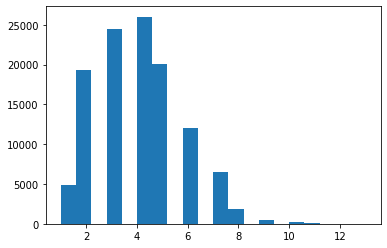

In [15]:
plt.hist(lengths,bins=20)

Load Embeddings

In [16]:
t_model = gensim.models.Word2Vec.load('../resources/models/word vectors/word2vec/wiki/full_grams_cbow_100_wiki/full_grams_cbow_100_wiki.mdl')

In [17]:
i2l = list(set(normalization(araby.LETTERS)))
i2v = {}
for index,letter in enumerate(i2l):
    if letter in t_model.wv.index_to_key :
        i2v[index] = t_model.wv.get_vector(letter)

In [18]:
i2v.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [19]:
i2l.append(' ')#Space
i2l.append('s')#eos
i2l.append('E')#Empty
i2l.append('X')#UNK
i2l.append('P')#pad

In [20]:
l2i = {v:i for i,v in enumerate(i2l)}

In [21]:
len(i2l)

34

ALL in Model

In [39]:
from torch.utils.data import Dataset,DataLoader

In [40]:
from torch.nn.utils.rnn import pad_sequence 

In [57]:
def noise(txt):
    sz = int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [186]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return (X,Y)

In [187]:
trn_data, val_data = msa_data[:int(0.8*len(msa_data))],msa_data[int(0.8*len(msa_data)):]

In [188]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [189]:
trn_ds[0]

(tensor([12, 21, 29, 21, 15,  2,  5, 29, 28, 21, 20, 11,  8, 29, 13,  8, 18,  7,
         29, 21, 12, 21, 29,  5,  2, 18, 24, 21, 29, 28, 29, 12,  8, 21, 29,  9,
          2,  5,  8, 29, 28, 29,  5, 27,  8, 21, 30, 21, 13,  8, 18]),
 tensor([18]))

In [276]:
def collate_fn(data):
    label  = [i for _,i in data]
    label = pad_sequence(label,batch_first=True,padding_value=32)
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=32)
    return label,label

In [277]:
trn_dl = DataLoader(trn_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)

Model

In [278]:
import torch, torch.nn as nn

In [279]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.gru = nn.GRU(vs,hs,num_layers=3,bidirectional=bidirectional,batch_first=True,dropout=0.2)
        self.lin = nn.Sequential(nn.Linear(2*hs if bidirectional == True else hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        x,_ = self.gru(x)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.softmax(x,dim=-1).view(bs*seq_len,-1)

In [280]:
num_emb = len(i2l)

In [281]:
model = autocorrect(num_emb,100,512).cuda()

In [282]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [283]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [284]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [285]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in trn_dl:
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in val_dl:
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [287]:
train(4,model,trn_dl,val_dl,loss)

train_loss -> 2.825662136077881 val_loss -> 2.883354663848877
train_loss -> 3.1756622791290283 val_loss -> 3.191047191619873
train_loss -> 2.775662899017334 val_loss -> 3.1141245365142822
train_loss -> 3.025662899017334 val_loss -> 3.037201166152954


## N-Gram Model

In [45]:
import random

In [50]:
def get_ngrams(txt,ws=11):
    ignore = ws //2
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='P',right_pad_symbol='P')
    return list(grams)[ignore:-ignore]

In [48]:
msa_grams=[]
for txt in msa_data:
    msa_grams.extend(get_ngrams(txt))

In [137]:
random.random()

0.6457555610677899

In [130]:
def noise(txt):
    replace_idx = len(txt)//2
    letter = txt[replace_idx]
    txt=list(txt)
    del txt[replace_idx]
    
    return ''.join(txt),letter

In [131]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X,Y = noise(self.data[idx])
        #numerilize
        X = torch.tensor([self.l2i.get(i,self.l2i['X']) for i in X])
        Y = torch.tensor([self.l2i.get(i,self.l2i['X']) for i in [Y]])
        
        return (X,Y)

In [132]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [133]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [195]:
def collate_fn(data):
    label  = [i for _,i in data]
    #label = pad_sequence(label,batch_first=True,padding_value=32)
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=33)
    return data,label

In [196]:
trn_dl = DataLoader(trn_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)

In [197]:
next(iter(trn_dl))

(tensor([[12, 21, 29,  ..., 13,  8, 18],
         [21, 29, 21,  ...,  8, 18, 29],
         [29, 21, 15,  ..., 18, 29,  7],
         ...,
         [28, 29, 12,  ..., 29, 27, 17],
         [29, 12,  8,  ..., 27, 17, 28],
         [12,  8, 21,  ..., 17, 28, 25]]),
 [tensor([5]),
  tensor([7]),
  tensor([14]),
  tensor([7]),
  tensor([3]),
  tensor([1]),
  tensor([2]),
  tensor([11]),
  tensor([22]),
  tensor([3]),
  tensor([15]),
  tensor([14]),
  tensor([12]),
  tensor([14]),
  tensor([25]),
  tensor([2]),
  tensor([13]),
  tensor([27]),
  tensor([16]),
  tensor([25]),
  tensor([24]),
  tensor([16]),
  tensor([29]),
  tensor([7]),
  tensor([28]),
  tensor([21]),
  tensor([5]),
  tensor([19]),
  tensor([6]),
  tensor([10]),
  tensor([17]),
  tensor([28])])

Model

In [198]:
import torch, torch.nn as nn

In [247]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True,dropout=0.2)
        self.dec_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True,dropout=0.2)
        self.lin = nn.Linear(hs,num_emb)
    def forward(self,x):
        
        bs,seq_len=x.shape
        print(bs)
        x = self.emb(x)
        _,x = self.gru(x)
        x = x.permute(1,0,2)
        x=x.reshape(32,-1)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.softmax(x,dim=-1).view(bs*seq_len,-1)

In [248]:
num_emb = len(i2l)

In [249]:
model = autocorrect(num_emb,100,512).cuda()

In [122]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [123]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [124]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [125]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in trn_dl:
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in val_dl:
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [126]:
train(50,model,trn_dl,val_dl,loss)

train_loss -> 2.966956377029419 val_loss -> 2.9245524406433105
train_loss -> 2.8179426193237305 val_loss -> 2.78366756439209
train_loss -> 2.713853597640991 val_loss -> 2.6620876789093018
train_loss -> 2.671865463256836 val_loss -> 2.632185459136963
train_loss -> 2.6573901176452637 val_loss -> 2.611616373062134
train_loss -> 2.6203505992889404 val_loss -> 2.578900098800659
train_loss -> 2.6199350357055664 val_loss -> 2.5786995887756348
train_loss -> 2.612917900085449 val_loss -> 2.5740554332733154
train_loss -> 2.6128077507019043 val_loss -> 2.5739822387695312
train_loss -> 2.6127774715423584 val_loss -> 2.5739588737487793
train_loss -> 2.563910722732544 val_loss -> 2.573953866958618
train_loss -> 2.5590922832489014 val_loss -> 2.5646677017211914
train_loss -> 2.559047222137451 val_loss -> 2.5551881790161133
train_loss -> 2.558993101119995 val_loss -> 2.5551440715789795
train_loss -> 2.556666374206543 val_loss -> 2.5520050525665283
train_loss -> 2.5519909858703613 val_loss -> 2.5488660

# Seq to Seq

In [22]:
from torch.utils.data import Dataset,DataLoader
import tqdm
import random

In [23]:
def get_ngrams(txt,ws=5):
    ignore = ws-2
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='Q',right_pad_symbol='W')
    return list(grams)[ignore:-ignore]

In [24]:
fake_data = ['غ' * 10]*500

In [85]:
msa_grams=[]
for txt in msa_data[:200]:
    ng = get_ngrams(txt)
    if ng:
        msa_grams.extend(ng)

In [86]:
len(msa_grams)

6029

In [87]:
def noise(txt):
    sz = int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [88]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        #X = noise(self.data[idx])
        X = self.data[idx]
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return torch.stack([X,Y])

In [89]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [90]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [91]:
trn_dl = DataLoader(trn_ds,batch_size=4,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=4,drop_last=False)

Model

In [92]:
import torch, torch.nn as nn

In [94]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.dec_gru = nn.GRU(hs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.lin = nn.Sequential(nn.Linear(hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        #print('emb',x.shape)
        x = self.enc_gru(x)
        #print('enc',x[0].shape)
        op=[]
        sos = torch.zeros(bs,1,self.hs).cuda()
        h = x[1]
        for i in range(5):
            sos,h = model.dec_gru(sos,h)
            op.append(h.detach())
        #    print('h',h.shape)
        print(len(x),len(x[0]))
        x = torch.stack(op,dim=1).squeeze().permute(1,0,2)
        
        x = self.lin(x)
        #print('lin',x.shape)
        return torch.softmax(x,dim=-1).permute(0,2,1).contiguous().view(bs*seq_len,-1)

In [95]:
num_emb = len(i2l)

In [96]:
model = autocorrect(num_emb,32,100).cuda()

In [97]:
#Load available vectors
#model.emb.weight.requires_grad_(False)
#for i in i2v.keys():
#    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
#model.emb.weight.requires_grad_(True);

In [98]:
opt = torch.optim.Adam(model.parameters(),lr=1e-2)

In [99]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [100]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm.tqdm(trn_dl,'train'):
            opt.zero_grad()
            ip,label = batch[:,0,:],batch[:,1,:]
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.contiguous().view(-1).cuda())
            trn_l.backward()
            opt.step()
            print(trn_l)
        with torch.no_grad():
            model.eval()
            for batch in tqdm.tqdm(val_dl,'validation'):
                ip,label = batch[:,0,:],batch[:,1,:]
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.contiguous().view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [101]:
train(2,model,trn_dl,val_dl,loss)

train:  13%|█▎        | 38/302 [00:00<00:00, 372.10it/s]

2 4
tensor(3.5260, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5263, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5249, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5226, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5221, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5277, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5225, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5242, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5183, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5203, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5104, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4857, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4601, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4848, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5038, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4393, device='cuda:0', grad_fn=<NllLossBac

train:  40%|███▉      | 120/302 [00:00<00:00, 391.22it/s]

tensor(3.4263, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3535, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3616, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4137, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5040, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4526, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3513, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3499, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3621, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4247, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4169, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3046, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4463, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2953, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3870, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2876, device='cuda:0', grad_fn=<NllLossBackwar

train:  68%|██████▊   | 204/302 [00:00<00:00, 402.87it/s]

tensor(3.2549, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2406, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4114, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4616, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4169, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3281, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2799, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.1781, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3349, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4084, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2724, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2449, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4574, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4963, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3993, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3363, device='cuda:0', grad_fn=<NllLossBackwar

train: 100%|██████████| 302/302 [00:00<00:00, 396.11it/s]


tensor(3.3169, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3351, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2869, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2737, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3107, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3225, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4623, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3173, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4426, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2446, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4226, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3856, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3553, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4336, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3255, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3777, device='cuda:0', grad_fn=<NllLossBackwar

validation:   0%|          | 0/1206 [00:00<?, ?it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  14%|█▍        | 172/1206 [00:00<00:01, 860.04it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  21%|██▏       | 259/1206 [00:00<00:01, 855.32it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  29%|██▉       | 347/1206 [00:00<00:00, 861.23it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  36%|███▌      | 434/1206 [00:00<00:00, 837.97it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  43%|████▎     | 520/1206 [00:00<00:00, 842.86it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  50%|█████     | 605/1206 [00:00<00:00, 835.76it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  57%|█████▋    | 691/1206 [00:00<00:00, 840.76it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  64%|██████▍   | 777/1206 [00:00<00:00, 845.55it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  72%|███████▏  | 863/1206 [00:01<00:00, 847.57it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  79%|███████▊  | 948/1206 [00:01<00:00, 846.24it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  86%|████████▌ | 1034/1206 [00:01<00:00, 848.89it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  93%|█████████▎| 1119/1206 [00:01<00:00, 840.59it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation: 100%|██████████| 1206/1206 [00:01<00:00, 842.72it/s]


2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 3
train_loss -> 3.323188304901123 val_loss -> 3.242037296295166


train:   0%|          | 0/302 [00:00<?, ?it/s]

2 4
tensor(3.3782, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5325, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3557, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2246, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3615, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.5001, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3712, device='cuda:0', grad_fn=<NllLossBackward>)


train:  12%|█▏        | 36/302 [00:00<00:00, 355.76it/s]

2 4
tensor(3.4208, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4222, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4649, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4926, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3125, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2172, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3027, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4701, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3181, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3133, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2966, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2699, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2815, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3124, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3832, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3793, device='cuda:0', grad_fn=<NllLossBac

train:  25%|██▌       | 76/302 [00:00<00:00, 376.52it/s]

tensor(3.2866, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4021, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4524, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4713, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4156, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3292, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3547, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3571, device='cuda:0', grad_fn=<NllLossBackward>)
2 4


train:  38%|███▊      | 115/302 [00:00<00:00, 381.36it/s]

tensor(3.5128, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4705, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2667, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2747, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3610, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3810, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4077, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2773, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4270, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2952, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3760, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2599, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3352, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3755, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3760, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4771, device='cuda:0', grad_fn=<NllLossBackwar

train:  51%|█████     | 154/302 [00:00<00:00, 381.73it/s]

tensor(3.3139, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2660, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3550, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3532, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2601, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3269, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.1655, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2606, device='cuda:0', grad_fn=<NllLossBackward>)
2 4


train:  64%|██████▍   | 193/302 [00:00<00:00, 381.56it/s]

tensor(3.2983, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4487, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3848, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2947, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2411, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2081, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3352, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3883, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2722, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.1921, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3917, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4009, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3381, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3221, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2779, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2136, device='cuda:0', grad_fn=<NllLossBackwar

train:  77%|███████▋  | 232/302 [00:00<00:00, 380.17it/s]

tensor(3.4702, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3899, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2964, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3574, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2973, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2491, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2696, device='cuda:0', grad_fn=<NllLossBackward>)
2 4


train:  90%|████████▉ | 271/302 [00:00<00:00, 375.45it/s]

tensor(3.2486, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3173, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2839, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3040, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3278, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3305, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3095, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2677, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2827, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3393, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4333, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3122, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4450, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2244, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4023, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3611, device='cuda:0', grad_fn=<NllLossBackwar

train: 100%|██████████| 302/302 [00:00<00:00, 377.33it/s]


tensor(3.3270, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.4663, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.3789, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2865, device='cuda:0', grad_fn=<NllLossBackward>)
2 4
tensor(3.2543, device='cuda:0', grad_fn=<NllLossBackward>)
2 2
tensor(3.3667, device='cuda:0', grad_fn=<NllLossBackward>)


validation:   0%|          | 0/1206 [00:00<?, ?it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:   7%|▋         | 83/1206 [00:00<00:01, 821.72it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  14%|█▍        | 166/1206 [00:00<00:01, 803.71it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  20%|██        | 247/1206 [00:00<00:01, 779.00it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  27%|██▋       | 325/1206 [00:00<00:01, 762.31it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  33%|███▎      | 402/1206 [00:00<00:01, 763.12it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  40%|████      | 484/1206 [00:00<00:00, 781.31it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  47%|████▋     | 564/1206 [00:00<00:00, 787.19it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  54%|█████▍    | 649/1206 [00:00<00:00, 805.35it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  61%|██████    | 735/1206 [00:00<00:00, 820.15it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  68%|██████▊   | 820/1206 [00:01<00:00, 827.91it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  75%|███████▍  | 903/1206 [00:01<00:00, 827.36it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  82%|████████▏ | 986/1206 [00:01<00:00, 824.04it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  89%|████████▊ | 1070/1206 [00:01<00:00, 826.02it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4


validation:  96%|█████████▌| 1156/1206 [00:01<00:00, 833.82it/s]

2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 

validation: 100%|██████████| 1206/1206 [00:01<00:00, 811.02it/s]

4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 3
train_loss -> 3.366666793823242 val_loss -> 3.2380597591400146


In [109]:
a = iter(val_dl)

In [150]:
d = next(a)

In [151]:
d.shape

torch.Size([4, 2, 5])

In [152]:
d[0]

tensor([[29, 28,  3, 28, 29],
        [29, 28,  3, 28, 29]])

In [153]:
model(d[0].cuda()).argmax(-1)

2 2


tensor([29, 28, 29, 29, 29, 29, 28, 29, 29, 29], device='cuda:0')

In [202]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.lin = nn.Linear(vs,num_emb)
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        #print('emb',x.shape)
        x = self.lin(x)
        x = torch.softmax(x,dim=-1)
        
        return x.view(bs*seq_len,-1)